In [59]:
from model import TIPINN_Cooling
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import pandas as pd
import pickle
import scienceplots
import os
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style()


## Train Models against each other

In [8]:
if not os.path.exists("cooling_models.pkl"):
    epochs = 15_000
    params = [
        {"phys_loss": True, "topo_loss": False, "ols_loss": False, "lr":1e-5, "epochs":epochs},
        {"phys_loss": False, "topo_loss": True, "ols_loss": False, "lr":1e-5, "epochs":epochs}
    ]
    cooling_records = []
    for param in params:
        cooling = TIPINN_Cooling(**param)
        losses = cooling.fit(cooling.approx_times, cooling.approx_temps)
        predict = cooling.predict(cooling.true_times)
        data = param | {'losses': losses, 'prediction': predict, 'times': cooling.true_times, "states": deepcopy(cooling.state_dict())}
        cooling_records.append(data)
    cooling_records_dict = dict(enumerate(cooling_records))
    with open("cooling_models.pkl", 'wb') as cooling_pickle:
        pickle.dump(cooling_records_dict, cooling_pickle)
else:
    with open("cooling_models.pkl", "rb") as cooling_pickle:
        cooling_records = list(pickle.load(cooling_pickle).values())
    cooling = TIPINN_Cooling()

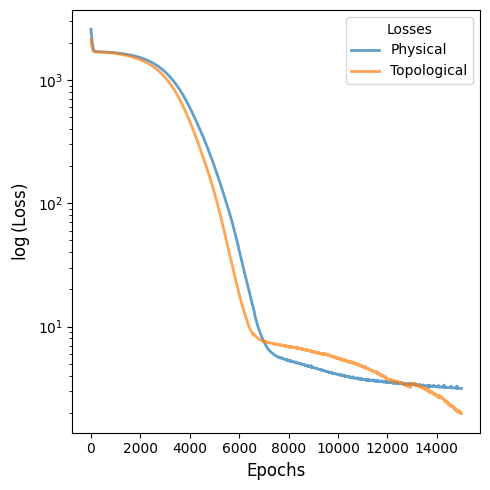

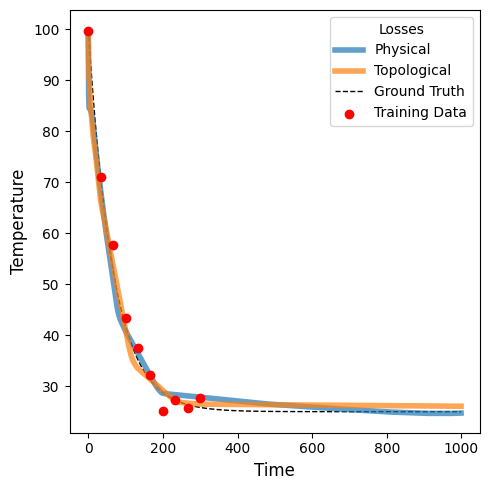

In [4]:
plt.style.use('science')
mpl.rcParams.update(mpl.rcParamsDefault)
fig0, ax0 = plt.subplots(figsize = (5, 5 ))
fig1, ax1 = plt.subplots(figsize = (5, 5))
for record in cooling_records:
    xs = range(len(record['losses']))
    ys = range(len(record['prediction']))
    if record['phys_loss']:
        label = 'Physical'
        ax0.plot(xs, record['losses'], label = label, lw = 2, alpha = 0.7)
        ax1.plot(ys, record['prediction'].numpy().flatten(), label = label, lw = 4, alpha = 0.7)
    elif not record['ols_loss'] and record['topo_loss']:
        label = 'Topological'
        ax0.plot(xs, record['losses'], label = label, lw = 2, alpha = 0.7)
        ax1.plot(ys, record['prediction'].numpy().flatten(), label = label, lw = 4, alpha = 0.7)

ax0.set_ylabel("$\log$(Loss)", fontsize = 12)
ax0.set_xlabel("Epochs", fontsize = 12)
ax0.set_yscale('log')
ax0.legend(title = 'Losses')

ax1.set_ylabel('Temperature', fontsize = 12)
ax1.set_xlabel("Time", fontsize = 12)
ax1.plot(ys, cooling.true_temps, label = 'Ground Truth', lw = 1, color = 'black', linestyle = '--', zorder = 1)
ax1.scatter(cooling.approx_times, cooling.approx_temps, label = 'Training Data', color = 'red', zorder = 2)
ax1.legend(title = 'Losses')

fig0.tight_layout()
fig1.tight_layout()

fig0.savefig("./imgs/cooling_law_with_diff_losses_0.svg")
fig1.savefig("./imgs/cooling_law_with_diff_losses_1.svg")
plt.show()

## Look at predictions for varying noise levels

In [60]:
if not os.path.exists("cooling_noise_comparison.pkl"):
    epochs = 15_000
    noise_params = [
        {"phys_loss": False, "topo_loss": True, "lr":1e-5, "epochs":epochs, "noise_intensity": 4},
        {"phys_loss": True, "topo_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 4},
        {"phys_loss": False, "topo_loss": True, "lr":1e-5, "epochs":epochs, "noise_intensity": 6},
        {"phys_loss": True, "topo_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 6},
        {"phys_loss": False, "topo_loss": True, "lr":1e-5, "epochs":epochs, "noise_intensity": 8},
        {"phys_loss": True, "topo_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 8},
    ]
    noise_records = []
    for noise_param in noise_params:
        cooling = TIPINN_Cooling(**noise_param,)
        losses = cooling.fit(cooling.approx_times, cooling.approx_temps)
        predict = cooling.predict(cooling.true_times)
        data = noise_param | {
            'losses': losses, 
            'prediction': predict,
            'times': cooling.true_times, 
            "states": deepcopy(cooling.state_dict()),
            "noisy_times": cooling.approx_times,
            "noisy_temps": cooling.approx_temps
        }
        noise_records.append(data)
    noise_records_dict = dict(enumerate(noise_records))
    with open("cooling_noise_comparison.pkl", 'wb') as noise_pickle:
        pickle.dump(noise_records_dict, noise_pickle)
else:
    with open("cooling_noise_comparison.pkl", "rb") as noise_pickle:
        noise_records = pickle.load(noise_pickle).values()
    noise_class = TIPINN_Cooling()

In [37]:
pred_frames = []
for noise in noise_records:
    frame = pd.DataFrame(
        {
            "Prediction": noise['prediction'].numpy().flatten(),
            "Times": noise['times'].flatten()
        }
    )
    frame['Loss'] = 'Physical' if noise['phys_loss'] else 'Topological'
    frame['Noise Intensity'] = noise['noise_intensity']
    pred_frames.append(frame)
pred_frame = pd.concat(pred_frames, axis = 0, ignore_index=True)
pred_frame.head()

,Prediction,Times,Loss,Noise Intensity
0,103.879715,0.000000,Topological,4
1,95.676170,1.001001,Topological,4
2,89.234604,2.002002,Topological,4
3,86.712364,3.003003,Topological,4
4,84.399040,4.004004,Topological,4


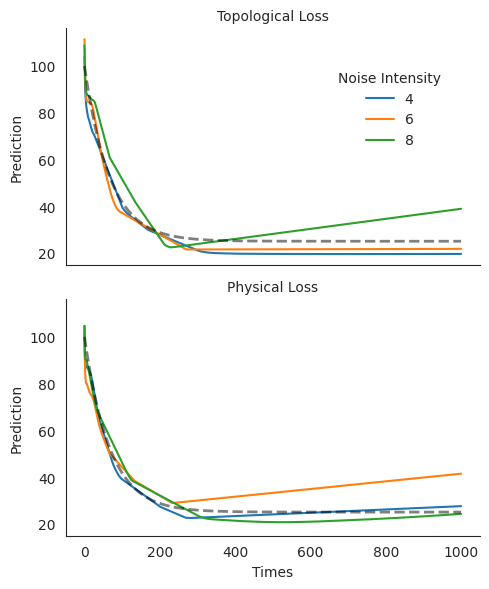

In [103]:
sns.set_style(style = "white")
sns.color_palette()
g = sns.relplot(
    pred_frame,
    x = "Times",
    y = "Prediction",
    hue='Noise Intensity',
    row = 'Loss',
    aspect=1.3,
    height=3,
    kind = 'line',
    palette="tab10",
)
g.set_titles("{row_name} Loss")
for ax in g.axes.tolist():
    ax[0].plot(noise_class.true_times, noise_class.true_temps, lw = 2, linestyle = '--', color = 'black', alpha = 0.5)
leg = g._legend
plt.tight_layout()
leg.set_bbox_to_anchor([0.9,0.8])
plt.savefig("/workspaces/TIPINN/imgs/intensity_prediction.svg", transparent = True)
plt.show()